In [12]:
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install gaussian_adaptive_attention
!pip install datasets

# Objective

As previous notebooks have shown we have already attempted to fully integrate the GAAM block into the GPT2 model with little to no success. In the following notebook we try to further utilise the GPT2 model by probing it with our training data to obtain an intermediate step where we gather the output encodings and then feeding this again through classifer which utilises the Gaussian attention mechanism we have been provided with from the GAAM authors.


## Our Intermediate GPT2

Below is an implementation to load a GPT2Model but instead of returning a prediction or classification we return the hidden states obtained during processing


In [1]:
import torch
import utils

from transformers import GPT2Model, GPT2Config, GPT2Tokenizer

class GPT2WithIntermediateOutputs(GPT2Model):

    def __init__(self, config):

        super().__init__(config)

    def forward(self, input_ids, attention_mask=None):

        # Get embeddings from input

        input_shape = input_ids.size()

        input_ids = input_ids.view(-1, input_shape[-1])

        device = input_ids.device

        if attention_mask is None:

            attention_mask = torch.ones(input_shape, device=device)

        # Prepare attention mask

        if attention_mask.dim() == 3:

            extended_attention_mask = attention_mask[:, None, :, :]

        elif attention_mask.dim() == 2:

            extended_attention_mask = attention_mask[:, None, None, :]

        # Prepare head mask if needed

        head_mask = self.get_head_mask(None, self.config.n_layer)

        # Transformer layers

        hidden_states = self.wte(input_ids) + self.wpe(torch.arange(0, input_shape[-1], device=device))

        hidden_states = self.drop(hidden_states)

        output_shape = input_shape + (hidden_states.size(-1),)

        all_hidden_states = torch.empty((*output_shape, self.config.n_layer + 1), device=device)

        all_hidden_states[..., 0] = hidden_states

        for i, (block, layer_past) in enumerate(zip(self.h, [None]*len(self.h))):

            outputs = block(hidden_states, layer_past=layer_past, attention_mask=extended_attention_mask, head_mask=head_mask[i])

            hidden_states = outputs[0]

            all_hidden_states[..., i+1] = hidden_states

        # Concatenate all hidden states

        concatenated_outputs = all_hidden_states.permute(2, 0, 1, 3).reshape(self.config.n_layer + 1, -1, hidden_states.size(-1))

        return concatenated_outputs


# Example usage:

config = GPT2Config.from_pretrained("gpt2")

model = GPT2WithIntermediateOutputs(config)

print(model)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

input_ids = torch.tensor([tokenizer.encode("if the vocabulary is known, then the sequence length is correct")])

# Output will have dimensions: [num_layers + 1, batch_size, seq_length, features] (discard element 0 , that's the embedding initial layer)

outputs = model(input_ids)


print(outputs.shape)  # Output dimensions

GPT2WithIntermediateOutputs(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)
torch.Size([13, 12, 768])


## Initalisation of GAAM

In conversation with the authors of the paper, they suggest using the GAAM followed by two convolutional kernels followed by a fully connected layer. Here we noticed initially a few problems, as our sequence length is continually changing we had to make use of an Adaptive Average Pooling layer so that we can reduce the input dimensions to be consistent no matter which input tokens we are passing the model. 

In [2]:
import torch.nn as nn
from gaussian_adaptive_attention import MultiHeadGaussianAdaptiveAttention

class ClassifierWithGAAM(nn.Module):
    def __init__(self, num_classes, num_gaussians, norm_axis):
        super().__init__()
        self.gaam = MultiHeadGaussianAdaptiveAttention(
            norm_axis=norm_axis,  # Choose either -2 (sequence length) or 0 (layer number)
            num_heads=5,
            num_gaussians=num_gaussians,
            padding_value=0
        )
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.fc = nn.Linear(64, num_classes)  # This needs to be adjusted based on output size

    def forward(self, x):
        x = self.gaam(x.unsqueeze(0))  # Add channel dimension
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Initialize classifier
classifier = ClassifierWithGAAM(num_classes=4, num_gaussians=3, norm_axis=-2)


In [3]:
from datasets import Dataset, DatasetDict, load_dataset
import pandas as pd

dataset = load_dataset('ag_news')

# Use our utils package to get a percentage of the dataset
dataset_train_1percent = utils.take_a_percentage_of_data(dataset['train'], percentage=0.001)
dataset_test_1percent = utils.take_a_percentage_of_data(dataset['test'], percentage=0.01)

combined_dataset_1percent = DatasetDict({
    'train': dataset_train_1percent,
    'test': dataset_test_1percent
})

In [4]:
# Here we take our dataset, and run it throught the GPT2WithIntermediateOutputs to obtain our intermediate states we then save this to a pkl file.

utils.pickilisation(combined_dataset_1percent, tokenizer, model, 'test')
utils.pickilisation(combined_dataset_1percent, tokenizer, model, 'train')

## Training

Below we attempted several different variations to try and achieve a model with better than random accuracy. We found that using a lr = 0.01 was sufficient to steadily decrease the loss without too much random movement. Whilst initally the results appear promising it is clear from evaluating our model on the test set that the model is only overfitting and not generalising to the overall problem.

/var/folders/jq/ckyws6p13ln604kg6bdyrjbw0000gn/T/ipykernel_88409/1835615064.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(f).view(1, -1, 768).to(device)


Epoch 0: Average Loss: 36.87
Epoch 1: Average Loss: 51.33
Epoch 2: Average Loss: 37.56
Epoch 3: Average Loss: 43.40
Epoch 4: Average Loss: 45.58
Epoch 5: Average Loss: 40.70
Epoch 6: Average Loss: 37.26
Epoch 7: Average Loss: 38.50
Epoch 8: Average Loss: 40.79
Epoch 9: Average Loss: 40.81
Epoch 10: Average Loss: 38.87
Epoch 11: Average Loss: 37.27
Epoch 12: Average Loss: 37.41
Epoch 13: Average Loss: 38.66
Epoch 14: Average Loss: 39.16
Epoch 15: Average Loss: 38.45
Epoch 16: Average Loss: 37.37
Epoch 17: Average Loss: 36.87
Epoch 18: Average Loss: 37.18
Epoch 19: Average Loss: 37.70
Epoch 20: Average Loss: 37.83
Epoch 21: Average Loss: 37.46
Epoch 22: Average Loss: 36.93
Epoch 23: Average Loss: 36.70
Epoch 24: Average Loss: 36.92
Epoch 25: Average Loss: 37.25
Epoch 26: Average Loss: 37.32
Epoch 27: Average Loss: 37.09
Epoch 28: Average Loss: 36.79
Epoch 29: Average Loss: 36.69
Epoch 30: Average Loss: 36.83
Epoch 31: Average Loss: 36.97
Epoch 32: Average Loss: 36.93
Epoch 33: Average Lo

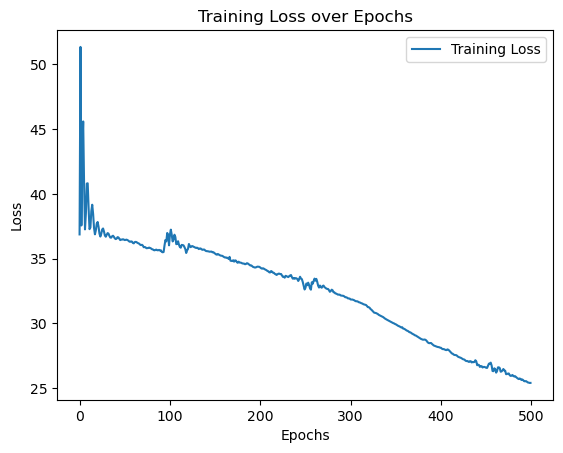

In [15]:
import pickle
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

use_classifier = classifier

with open('processed_train_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

optimizer = optim.Adam(use_classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Assuming the classifier is ready and 'device' is defined
use_classifier.to(device)
use_classifier.train()

# Prepare data
features, labels = zip(*processed_data)
features, labels = features[:32], labels[:32]
batch_size = 32
num_batches = len(features) // batch_size

num_epochs = 500
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0

    for i in range(0, len(features), batch_size):
        optimizer.zero_grad()

        for f, label in zip(features[i:i+batch_size], labels[i:i+batch_size]):
            x = torch.tensor(f).view(1, -1, 768).to(device)
            y = torch.tensor([label], dtype=torch.long).to(device)

            output = use_classifier(x)
            loss = criterion(output, y)
            loss.backward()
            total_loss += loss.item()

        optimizer.step()

    avg_loss = total_loss / num_batches
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch}: Average Loss: {avg_loss:.2f}")

# Plot the training loss over epochs
plt.plot(range(num_epochs), epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


In [16]:
import torch.optim as optim
import torch

with open('processed_train_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

use_classifier.to(device)
use_classifier.eval()
 
 
correct_predictions = 0
total_predictions = 0
c = 0


for x, label in processed_data:
    c += 1
    x = x.to(device)
    label = torch.tensor([label]).to(device)

    with torch.no_grad():
        flattened = x.view(1, -1, 768)
        output = use_classifier(flattened)
        predicted_label = torch.argmax(output, dim=1)
        if c % 10 == 0:
            print(f"Predicted on item {c}: {predicted_label.item()}, Actual: {label.item()}")

    correct_predictions += (predicted_label == label).sum().item()
    total_predictions += label.size(0)

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.4f}")


Predicted on item 10: 1, Actual: 0
Predicted on item 20: 1, Actual: 3
Predicted on item 30: 1, Actual: 1
Predicted on item 40: 0, Actual: 3
Predicted on item 50: 0, Actual: 1
Predicted on item 60: 2, Actual: 0
Predicted on item 70: 2, Actual: 2
Predicted on item 80: 1, Actual: 3
Predicted on item 90: 2, Actual: 2
Predicted on item 100: 3, Actual: 3
Predicted on item 110: 2, Actual: 0
Predicted on item 120: 3, Actual: 2
Accuracy: 0.3417


In [17]:
import torch
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed test data
with open('processed_test_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_classifier.to(device)
use_classifier.eval()

# Initialize lists to collect predicted and actual labels
all_predictions = []
all_labels = []
c = 0

for x, label in processed_data:
    c += 1
    x = x.to(device)
    label = torch.tensor([label]).to(device)

    with torch.no_grad():
        flattened = x.view(1, -1, 768)
        output = use_classifier(flattened)
        predicted_label = torch.argmax(output, dim=1)
        if c % 10 == 0:
            print(f"Predicted on item {c}: {predicted_label.item()}, Actual: {label.item()}")

    all_predictions.append(predicted_label.item())
    all_labels.append(label.item())

# Calculate accuracy
correct_predictions = np.sum(np.array(all_predictions) == np.array(all_labels))
total_predictions = len(all_labels)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.4f}")


Predicted on item 10: 2, Actual: 0
Predicted on item 20: 0, Actual: 3
Predicted on item 30: 0, Actual: 0
Predicted on item 40: 1, Actual: 3
Predicted on item 50: 0, Actual: 1
Predicted on item 60: 0, Actual: 3
Predicted on item 70: 1, Actual: 2
Accuracy: 0.2237


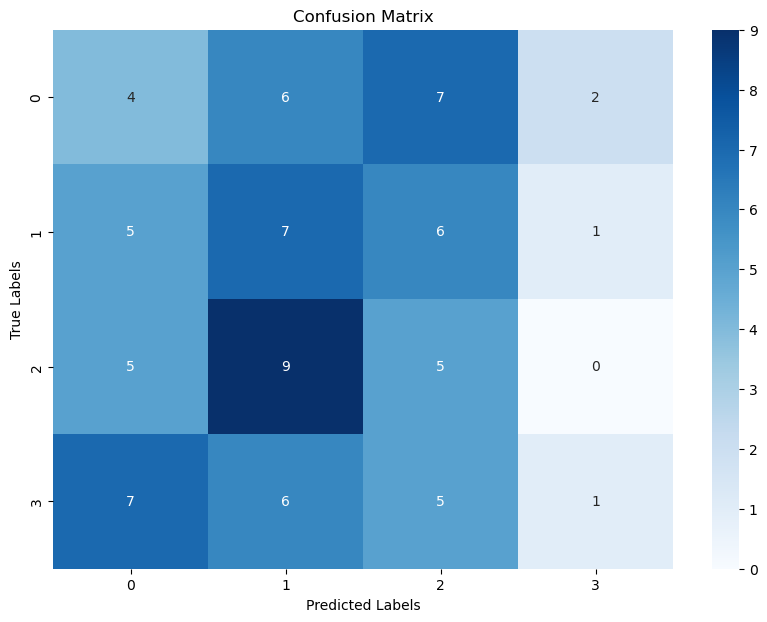

In [18]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()